# Benchmark: PXD014777 HeLa 10 replicate dataset

This notebook contains code to benchmark the PIPP model on [PXD014777 dataset](https://proteomecentral.proteomexchange.org/cgi/GetDataset?ID=PXD014777) - HeLa10replicates2h-1.0.10.4_MaxQuant.txt.zip. Here, we'll use two txt files from the dataset:

- allPeptides.txt: All the peptides with MS-1 data
- evidence.txt: A subset of the peptides in allPeptides.txt, which contains both MS-1 and MS-2 data

We'll use PIPP to compute the embeddings of each MS-1 datapoint. Followed by peptide identity propagation using the MS1/MS2 data as the support data.

Let's start with the imports.

In [1]:
%%capture

%matplotlib inline
%load_ext autoreload
%autoreload 2

from collections import defaultdict
import re
import os

import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pipp
import pipp.utils

np.random.seed(0)

Let's define the paths to the data and the pretrained model.

In [2]:
PEPTIDES_PATH = "../../data/HeLa10replicates/txt/allPeptides.txt"
EVIDENCE_PATH = "../../data/txt/HeLa10replicates/evidence.txt"
EVIDENCE_MAPPED_PATH = "../../data/HeLa10replicates/txt/evidence_mapped.txt" # @NOTE: file is auto-generated if it doesn't exist

PRETRAINED_MODEL_PATH = "../../data/PXD019086_PXD010012_combined_evidence_90Kto20Ksplit_5query_1shot_fullmodel_featuresScaled_allPeptidesTxtFeatures_modSeqSpecies_hidden64_latent10_maxEpoch300_164trainways_xlatent_conditionalEmbedding.pth"

## Data Preparation

Let's load and clean the data.

In [3]:
ms1_raw_data = pd.read_csv(PEPTIDES_PATH, sep='\t', header=0)

As mentioned in the introduction, the MS2 data is a subset of the MS1 data (with additional features). However, it is not trivial to map the MS2 data back to the MS1 data, due to small differences in feature values. Hence, we can't just compare the features: ['Raw file', 'Charge', 'm/z', 'Mass', 'Intensity', 'Retention time'].
Instead we'll compute a mapping here as we'll later need to know which entries in the MS1 data corresponds to the MS2 data. The indices in MS2 data will match those in MS1 data - after performing the "mapping".

In [4]:
if not os.path.isfile(EVIDENCE_MAPPED_PATH):
    ms2_raw_data = pd.read_csv(EVIDENCE_PATH, sep='\t', header=0, low_memory=False)
    ms2_raw_data = pipp.utils.link_MSMS_to_MS(ms2_raw_data, ms1_raw_data, verbose=True)
    ms2_raw_data.to_csv(EVIDENCE_MAPPED_PATH, sep='\t', index=True)

In [5]:
ms2_raw_data = pd.read_csv(EVIDENCE_MAPPED_PATH, sep='\t', header=0, low_memory=False, index_col=0)

Let's look at the dimensions of the data.

In [6]:
print('MS1 data shape:     {}'.format(ms1_raw_data.shape))
print('MS1+MS2 data shape: {}'.format(ms2_raw_data.shape))

MS1 data shape:     (4101555, 24)
MS1+MS2 data shape: (634466, 70)


### MS1 data preprocessing

Let's look at the features available in the MS1 data:

In [7]:
ms1_raw_data.columns.unique()

Index(['Raw file', 'Charge', 'm/z', 'Mass', 'Resolution',
       'Number of data points', 'Number of frames', 'Number of isotopic peaks',
       'Isotope correlation', 'Mass fractional part', 'Mass deficit',
       'Retention time', 'Retention length', 'Retention length (FWHM)',
       'Min frame index', 'Max frame index', 'Ion mobility index',
       'Ion mobility index length', 'Ion mobility index length (FWHM)',
       'Intensity', 'Intensities', 'Number of pasef MS/MS', 'Pasef MS/MS IDs',
       'MS/MS scan number'],
      dtype='object')

Let's filter out low quality peptides.

In [8]:
# filter out low quality peptides
ms1_data = ms1_raw_data.loc[(ms1_raw_data['Charge'] != 1) & (ms1_raw_data['Intensity'] > 0)]

In [9]:
ms1_raw_peptides_per_run = [np.sum(ms1_raw_data['Raw file'] == run) for run in ms1_raw_data['Raw file'].unique()]
ms1_peptides_per_run = [np.sum(ms1_data['Raw file'] == run) for run in ms1_data['Raw file'].unique()]

Text(0, 0.5, 'Number of peptides')

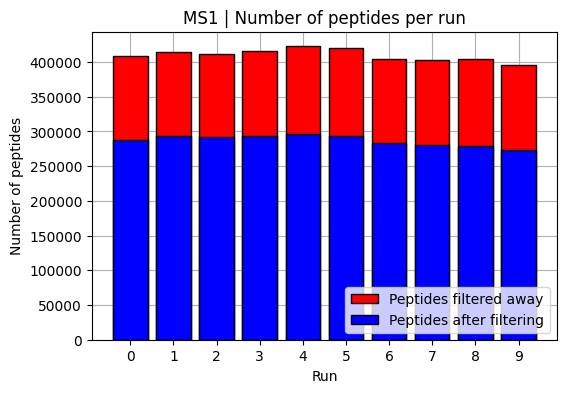

In [10]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.bar(range(len(ms1_raw_peptides_per_run)), ms1_raw_peptides_per_run, color='red', edgecolor='black')
ax.bar(range(len(ms1_peptides_per_run)), ms1_peptides_per_run, color='blue', edgecolor='black')
ax.legend(['Peptides filtered away', 'Peptides after filtering'], loc='lower right')

ax.grid(True)
ax.set_axisbelow(True)
ax.set_xticks(np.arange(0, len(ms1_raw_peptides_per_run), 1))
ax.set_title("MS1 | Number of peptides per run")
ax.set_xlabel("Run")
ax.set_ylabel("Number of peptides")

In [11]:
print(f"After filtering | MS1 data points: {ms1_data.shape[0]} ({ms1_data.shape[0] / ms1_raw_data.shape[0] * 100:.2f}%)")

After filtering | MS1 data points: 2871496 (70.01%)


### MS2 (MSMS) data preprocessing

Let's look at the features available in the MS2 data:

In [12]:
ms2_raw_data.columns.unique()

Index(['Sequence', 'Length', 'Modifications', 'Modified sequence',
       'Oxidation (M) Probabilities', 'Oxidation (M) Score Diffs',
       'Acetyl (Protein N-term)', 'Oxidation (M)', 'Missed cleavages',
       'Proteins', 'Leading proteins', 'Leading razor protein', 'Gene names',
       'Protein names', 'Type', 'Raw file', 'Experiment', 'MS/MS m/z',
       'Charge', 'm/z', 'Mass', 'Resolution',
       'Uncalibrated - Calibrated m/z [ppm]',
       'Uncalibrated - Calibrated m/z [Da]', 'Mass error [ppm]',
       'Mass error [Da]', 'Uncalibrated mass error [ppm]',
       'Uncalibrated mass error [Da]', 'Max intensity m/z 0', 'Retention time',
       'Retention length', 'Calibrated retention time',
       'Calibrated retention time start', 'Calibrated retention time finish',
       'Retention time calibration', 'Ion mobility index',
       'Ion mobility length', '1/K0', '1/K0 length', 'Calibrated 1/K0', 'CCS',
       'CCS length', 'Match time difference', 'Match m/z difference',
       '

Let's filter out low quality peptides.

In [13]:
# filter out low quality peptides
ms2_data = ms2_raw_data.loc[(ms2_raw_data['Charge'] != 1) & (ms2_raw_data['Intensity'] > 0)]

# keep the most intense peptides
ms2_data = ms2_data.loc[ms2_data.groupby(['Modified sequence', 'Charge', 'Raw file'])['Intensity'].idxmax()]

# remove contaminants
ms2_data = ms2_data.loc[[(not bool(re.search('CON__|REV__', i))) for i in ms2_data['Leading razor protein'].tolist()]]

# define identifier for each peptide
ms2_data['PrecursorID'] = ms2_data['Modified sequence'].astype(str).str.cat(ms2_data['Charge'].astype(str), sep='')

In [14]:
ms2_raw_peptides_per_run = [np.sum(ms2_raw_data['Raw file'] == run) for run in ms2_raw_data['Raw file'].unique()]
ms2_peptides_per_run = [np.sum(ms2_data['Raw file'] == run) for run in ms2_data['Raw file'].unique()]

Text(0, 0.5, 'Number of peptides')

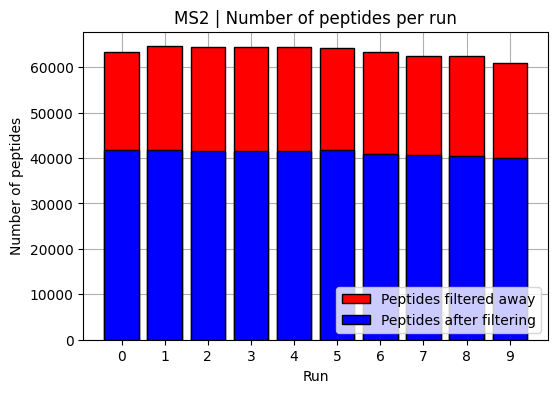

In [15]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.bar(range(len(ms2_raw_peptides_per_run)), ms2_raw_peptides_per_run, color='red', edgecolor='black')
ax.bar(range(len(ms2_peptides_per_run)), ms2_peptides_per_run, color='blue', edgecolor='black')
ax.legend(['Peptides filtered away', 'Peptides after filtering'], loc='lower right')

ax.grid(True)
ax.set_axisbelow(True)
ax.set_xticks(np.arange(0, len(ms2_raw_peptides_per_run), 1))
ax.set_title("MS2 | Number of peptides per run")
ax.set_xlabel("Run")
ax.set_ylabel("Number of peptides")

In [16]:
print(f"After filtering | MS2 data points: {ms2_data.shape[0]} ({ms2_data.shape[0] / ms2_raw_data.shape[0] * 100:.2f}%)")

After filtering | MS2 data points: 411838 (64.91%)


Let's see how many runs a peptide is present in.

In [17]:
peptide_abundances = ms2_data['PrecursorID'].value_counts()

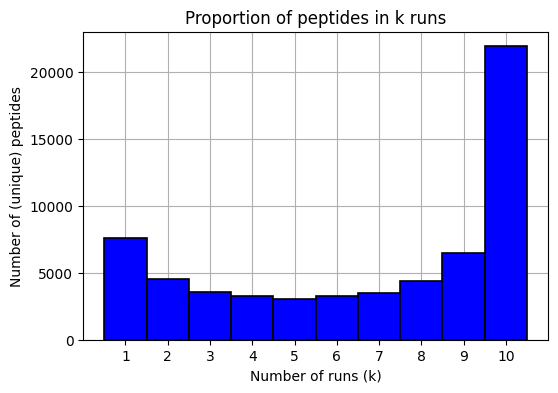

In [18]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(peptide_abundances, bins=range(1, np.max(peptide_abundances)+2), color='blue', edgecolor='black', linewidth=1.2, align='left')
ax.set_xticks(range(1, np.max(peptide_abundances)+1))
ax.set_title('Proportion of peptides in k runs')
ax.set_xlabel('Number of runs (k)')
ax.set_ylabel('Number of (unique) peptides')
ax.grid(True)
ax.set_axisbelow(True)

### Feature Extraction

Let's extract the features which the model takes as input.

It seems like the two datasets use a different name for 'Ion mobilility index length' / 'Ion mobility length'. Let's rename one of them to be consistent between the datasets.

In [19]:
ms1_data = ms1_data.copy()
ms1_data.rename(columns={'Ion mobility index length': 'Ion mobility length'}, inplace=True)

In [20]:
features = ['Charge', 'Mass', 'm/z', 'Retention time','Retention length', 'Ion mobility index', 'Ion mobility length','Number of isotopic peaks']

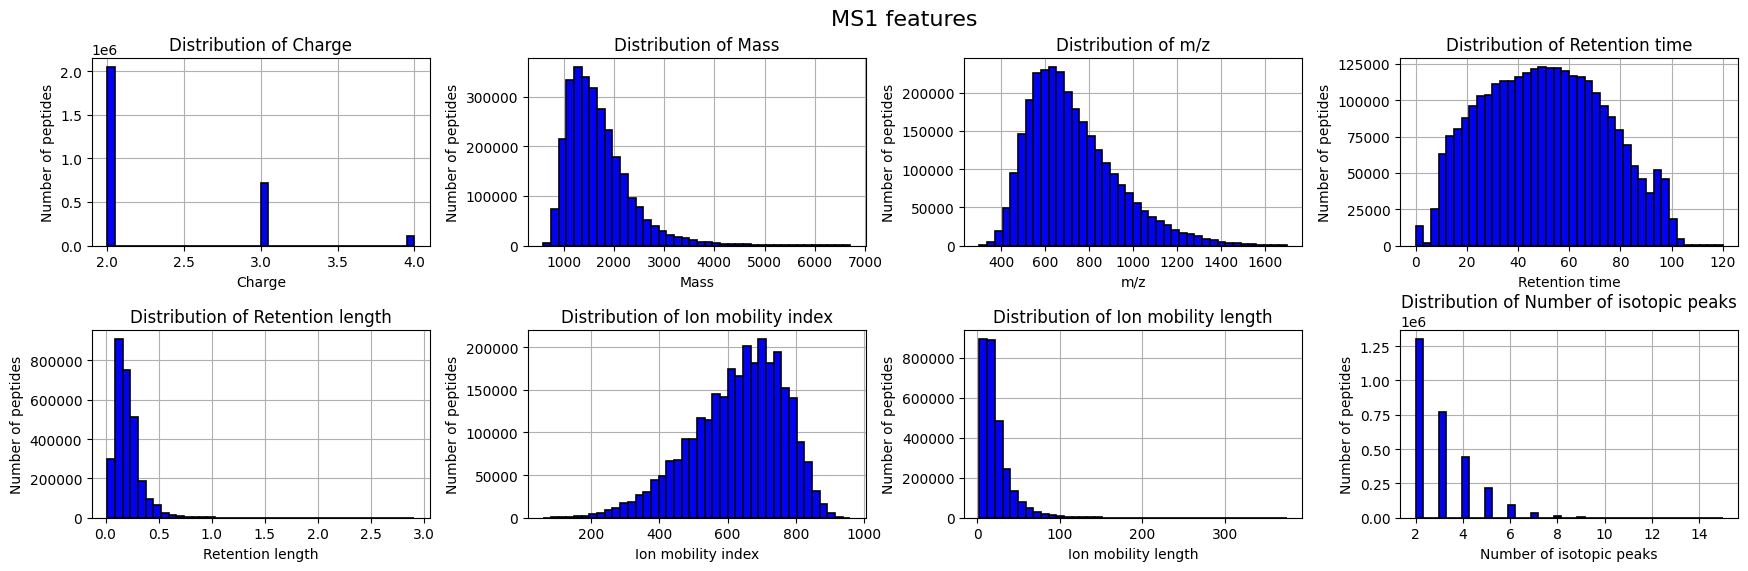

In [21]:
fig, axs = plt.subplots(figsize=(18, 6), ncols=4, nrows=2)
fig.tight_layout(pad=4.0)
fig.suptitle('MS1 features', fontsize=16)

for i, feature in enumerate(features):
    ax = axs[i // 4][i % 4]
    ax.hist(ms1_data[feature], bins=40, color='blue', edgecolor='black', linewidth=1.2)
    ax.set_xlabel(feature)
    ax.set_ylabel('Number of peptides')
    ax.set_title(f'Distribution of {feature}')
    ax.grid(True)
    ax.set_axisbelow(True)

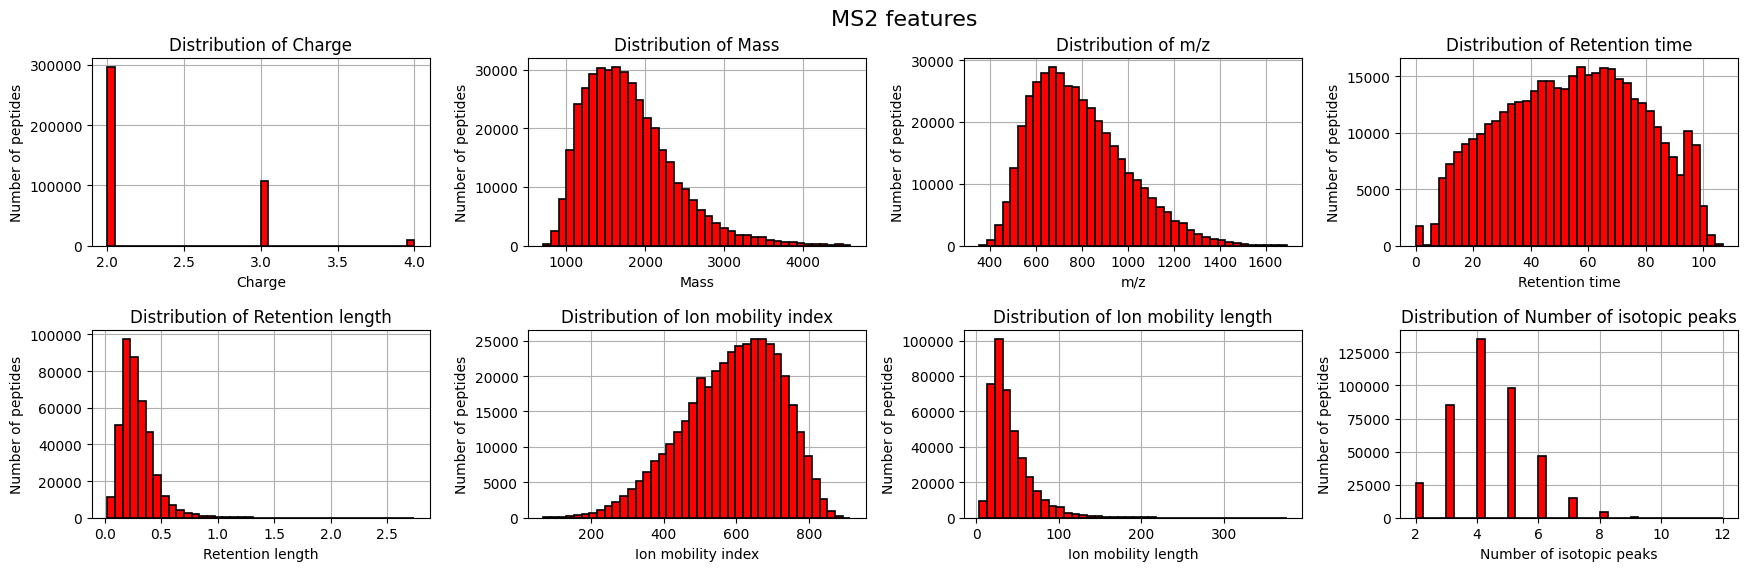

In [22]:
fig, axs = plt.subplots(figsize=(18, 6), ncols=4, nrows=2)
fig.tight_layout(pad=4.0)
fig.suptitle('MS2 features', fontsize=16)

for i, feature in enumerate(features):
    ax = axs[i // 4][i % 4]
    ax.hist(ms2_data[feature], bins=40, color='red', edgecolor='black', linewidth=1.2)
    ax.set_xlabel(feature)
    ax.set_ylabel('Number of peptides')
    ax.set_title(f'Distribution of {feature}')
    ax.grid(True)
    ax.set_axisbelow(True)

In [23]:
ms1_features = ms1_data[features]
ms2_features = ms2_data[features]

## PIPP model

### Computing the Embeddings

Let's load the model and compute the embeddings.

In [24]:
model = pipp.Peptideprotonet.load(PRETRAINED_MODEL_PATH)

In [25]:
ms1_embeddings = model.get_latent_representations(ms1_features)

In [26]:
ms2_embeddings = model.get_latent_representations(ms2_features)

In [27]:
ms1_embeddings = ms1_embeddings - np.mean(ms1_embeddings, axis=0)
ms2_embeddings = ms2_embeddings - np.mean(ms2_embeddings, axis=0)

Let's look at the embedding space.
We'll look at a subset of peptides due to memory limitations.

In [28]:
n = 50_000
random_indices = np.random.choice(range(len(ms2_embeddings)), size=n, replace=False)

Let's also add some "random" peptides to ensure all possible runs of at least a few peptides are included.

In [29]:
high_coverage_peptides_to_include = [
    '_(ac)AAAAAAAAAAGAAGGR_2',
    '_LGMENDDTAVQYAIGR_2',
    '_LGHVVMGNNAVSPYQQVIEK_2',
    '_LEEVLSTEGAEENGNSDK_2',
    '_PAPQMNGSTGDAR_2',
    '_HLQINQTFEELR_2',
    '_LLAGEDGTSER_2',
    '_LETMPLYLEDDIRPDIK_3',
    '_LFNDSSPVVLEESWDALNAITK_3',
]

low_coverage_peptides_to_include = [
    '_ELFEQYGAVYEINVLR_3',
    '_ELFDELVK_2',
    '_FLGDYVENLNK_2',
    '_HHSQQAPQAEAPCLLR_3',
    '_HFSTTTNNIQSR_2',
    '_LEEIAELVASSLPSPLR_3',
    '_AVLEQFGFPLTGTEAR_2',
    '_VPQFSFLDIFPK_2',
    '_VGPYHNPQETYHYYQLPVCCPEK_3',
    '_FDSASSSYYLDMHSLPHVINPVESR_4',
]

peptides_to_include = high_coverage_peptides_to_include + low_coverage_peptides_to_include

custom_indices = [ms2_data.index[ms2_data['PrecursorID'] == peptide].tolist() for peptide in peptides_to_include]
custom_indices = [peptide for peptide_runs in custom_indices for peptide in peptide_runs]
custom_indices = [ms2_data.index.get_loc(i) for i in custom_indices]

# print(peptides_abundances)

In [30]:
indices = np.unique(np.concatenate((random_indices, custom_indices)))

In [31]:
ms2_data_subset = ms2_data.iloc[indices]
ms2_embeddings_subset = ms2_embeddings[indices]

Let's compute the UMAP for plotting.

In [32]:
reducer = umap.UMAP(metric = 'cosine')
umap_embedding = reducer.fit_transform(ms2_embeddings_subset)

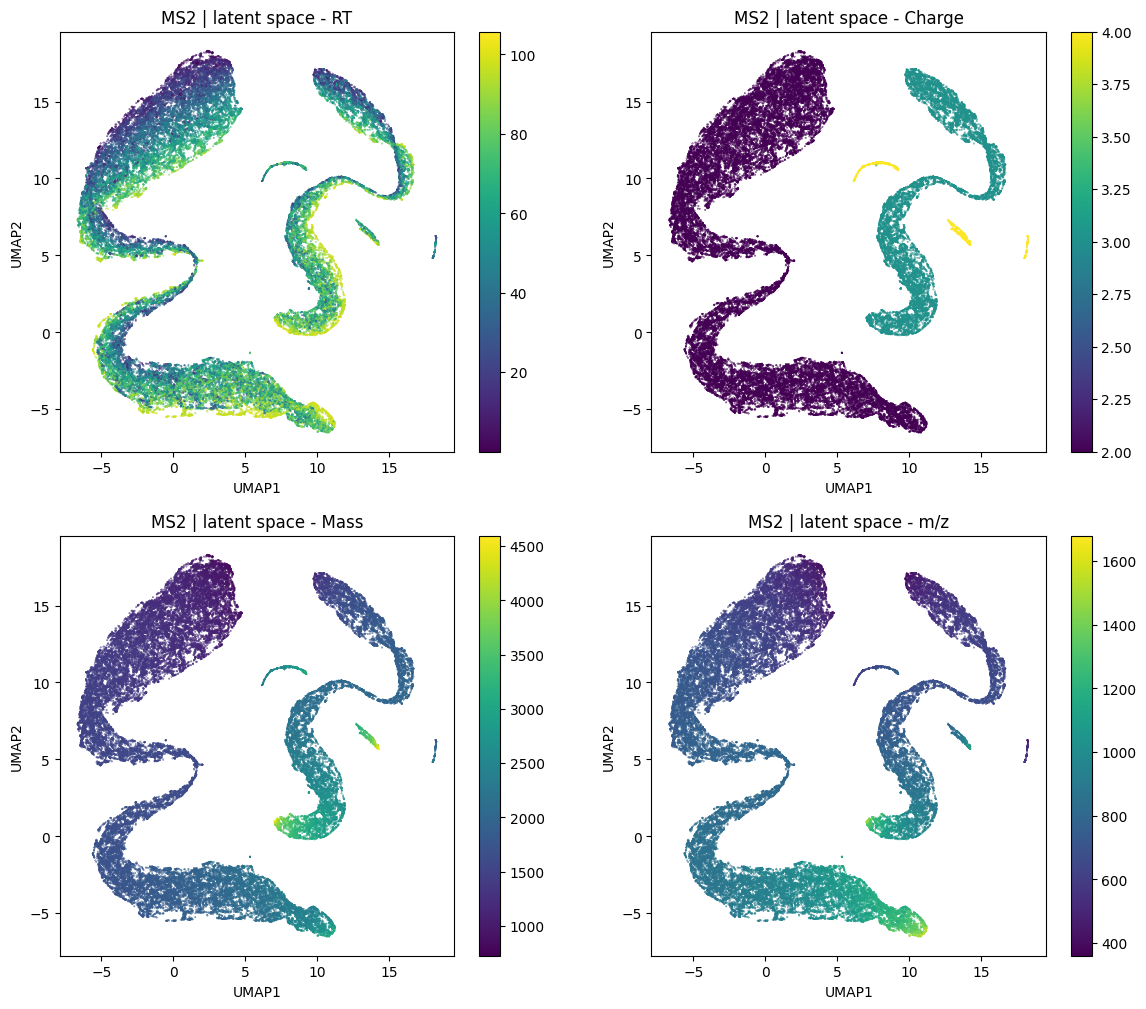

In [33]:
fig, axs = plt.subplots(figsize=(14, 12), ncols=2, nrows=2)

ax = axs[0][0]
sp = ax.scatter(umap_embedding[:,0], umap_embedding[:,1], c=ms2_data_subset['Retention time'], s=0.1)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('MS2 | latent space - RT')
fig.colorbar(sp)

ax = axs[0][1]
sp = ax.scatter(umap_embedding[:,0], umap_embedding[:,1], c=ms2_data_subset['Charge'], s=0.1)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('MS2 | latent space - Charge')
fig.colorbar(sp)

ax = axs[1][0]
sp = ax.scatter(umap_embedding[:,0], umap_embedding[:,1], c=ms2_data_subset['Mass'], s=0.1)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('MS2 | latent space - Mass')
fig.colorbar(sp)

ax = axs[1][1]
sp = ax.scatter(umap_embedding[:,0], umap_embedding[:,1], c=ms2_data_subset['m/z'], s=0.1)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('MS2 | latent space - m/z')
fig.colorbar(sp)

Let's also plot the latent space of the MS2 data together with some low coverage and high coverage peptides.

Text(0.5, 1.0, 'MS2 | latent space - low coverage peptides')

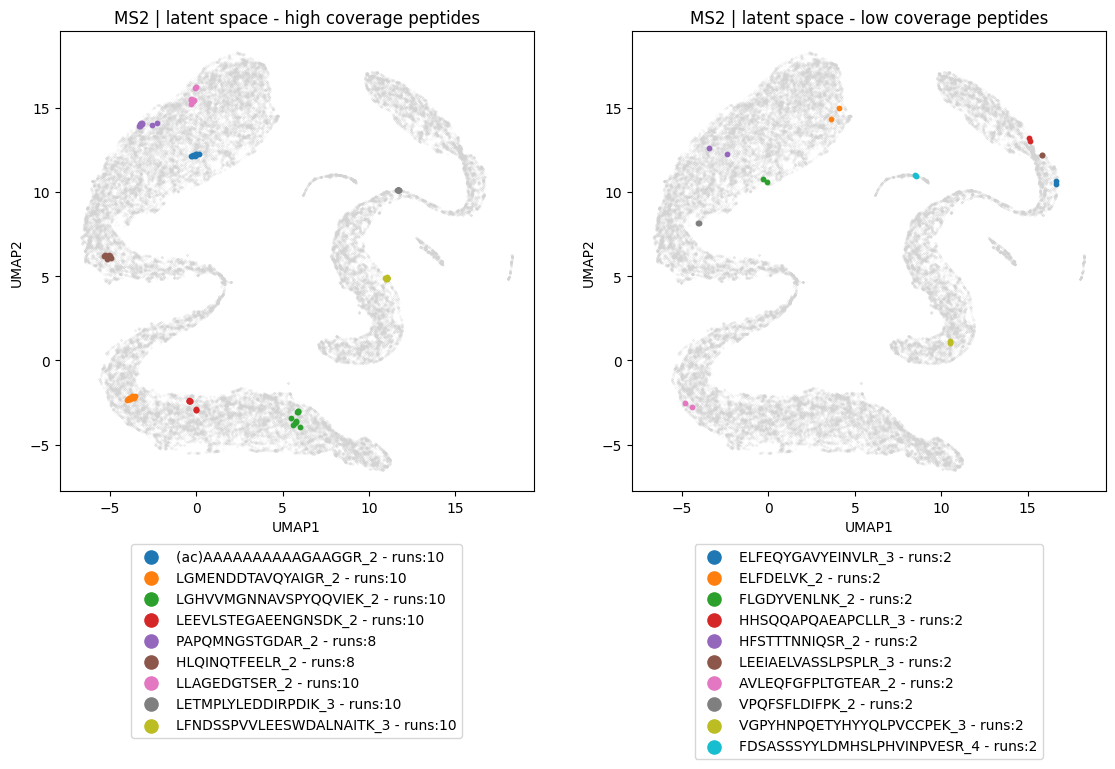

In [34]:
fig, axs = plt.subplots(figsize=(12, 6), ncols=2, nrows=1)
fig.tight_layout(pad=4.0)

# high coverage peptides
ax = axs[0]
ax.scatter(umap_embedding[:,0], umap_embedding[:,1], s=0.01, color='lightgrey')

for i, peptide in enumerate(high_coverage_peptides_to_include):
    peptide_ref_indices = np.where(ms2_data_subset['PrecursorID'] == peptide)
    ax.scatter(umap_embedding[peptide_ref_indices,0], umap_embedding[peptide_ref_indices,1], s=10, color=plt.cm.tab10(i), label=f"{peptide[1:]} - runs:{peptide_abundances[peptide]}")

ax.legend(markerscale=3, loc='upper center', bbox_to_anchor=(0.5, -0.1))
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('MS2 | latent space - high coverage peptides')

# low coverage peptides
ax = axs[1]
ax.scatter(umap_embedding[:,0], umap_embedding[:,1], s=0.01, color='lightgrey')

for i, peptide in enumerate(low_coverage_peptides_to_include):
    peptide_ref_indices = np.where(ms2_data_subset['PrecursorID'] == peptide)
    ax.scatter(umap_embedding[peptide_ref_indices,0], umap_embedding[peptide_ref_indices,1], s=10, color=plt.cm.tab10(i), label=f"{peptide[1:]} - runs:{peptide_abundances[peptide]}")

ax.legend(markerscale=3, loc='upper center', bbox_to_anchor=(0.5, -0.1))
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('MS2 | latent space - low coverage peptides')

## Peptide Identity Propagation

### Identification on the MS1 data

In [35]:
ms1_only_locs = ms1_data.index.difference(ms2_data.index)
ms1_only_ilocs = ms1_data.index.get_indexer(ms1_only_locs)

In [36]:
ms1_only = ms1_data.iloc[ms1_only_ilocs]

In [37]:
k = 15

identities, confidence = model.propagate(ms1_only, ms2_data, k_neighbours=k)

computing prototypes...
computing 15-nearest neighbour prototypes...
computing confidence and selecting identities...


In [38]:
print(f"Number of prototypes: {ms2_data['PrecursorID'].nunique()}")

Number of prototypes: 61517


Let's plot the distribution of the confidence scores for the MS1 identifications. Additionally, we'll add a threshold to the plot, which we'll use to filter out low confidence identifications.

Text(0.21000000000000002, 500000.0, 'Peptides identified: 6664 (0.27%)')

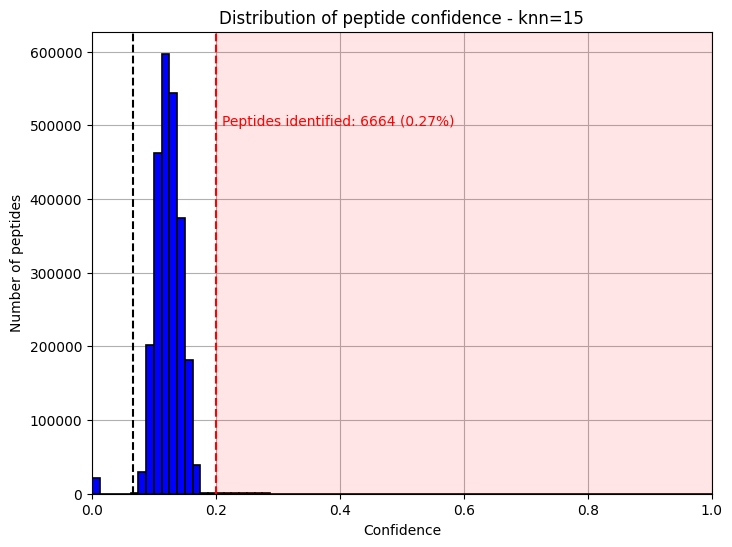

In [39]:
confidence_threshold = 0.2

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(confidence, bins=80, color='blue', edgecolor='black', linewidth=1.2)
ax.set_xlabel('Confidence')
ax.set_ylabel('Number of peptides')
ax.set_title(f'Distribution of peptide confidence - knn={k}')
ax.set_xlim([0, 1])
ax.grid(True)
ax.set_axisbelow(True)

ax.axvline(x=confidence_threshold, color='red', linestyle='--')
ax.axvline(x=1/k, color='black', linestyle='--')
ax.axvspan(confidence_threshold, 1, alpha=0.1, color='red')

identified_count = np.sum(confidence > confidence_threshold)
ax.text(confidence_threshold + 0.01, 5e5, f'Peptides identified: {identified_count} ({identified_count / len(ms1_only) * 100:.2f}%)', color='red')

Let's plot the number of peptides identified for different thresholds.

Text(0, 0.5, 'Percentage of peptides identified (%)')

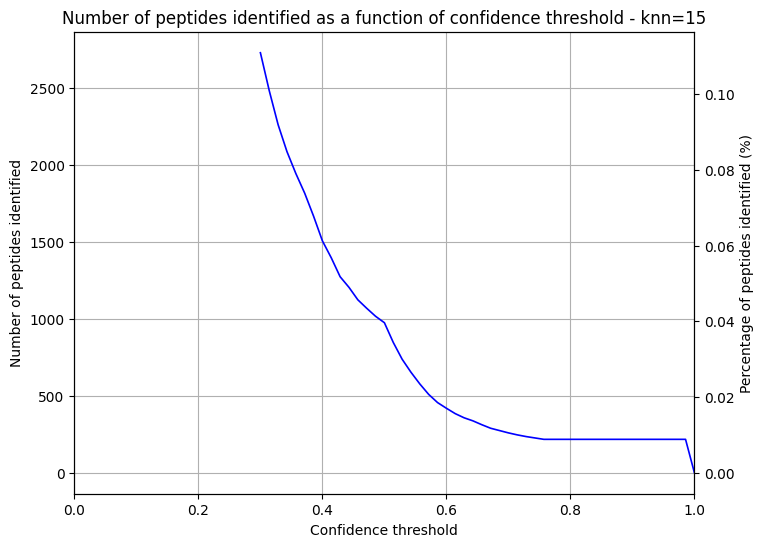

In [40]:
thresholds = np.linspace(0.3, 1, 50)
identified_counts = [np.sum(confidence > threshold) for threshold in thresholds]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(thresholds, identified_counts, color='blue', linewidth=1.2)

ax.set_xlabel('Confidence threshold')
ax.set_ylabel('Number of peptides identified')
ax.set_title(f'Number of peptides identified as a function of confidence threshold - knn={k}')
ax.set_xlim([0, 1])
ax.grid(True)
ax.set_axisbelow(True)

ax2 = ax.twinx()
ax2.plot(thresholds, np.array(identified_counts) / len(ms1_only) * 100, color='red', linewidth=0) # @NOTE: linewidth=0 to hide the line
ax2.set_ylabel('Percentage of peptides identified (%)')

Let's generate a dataframe with the results combining both the MS1 (excluding the MS2 data entries) and MS2 data using the features: run (raw file), Intensity, precursorID, confidence. We'll use these features to generate the expression matrices (and heatmaps).


In [41]:
ms1_expression_features = {
    'Raw file': ms1_only['Raw file'],
    'Intensities': ms1_only['Intensity'],
    'PrecursorID': identities,
    'Confidence': confidence,
}

ms2_expression_features = {
    'Raw file': ms2_data['Raw file'],
    'Intensities': ms2_data['Intensity'],
    'PrecursorID': ms2_data['PrecursorID'],
    'Confidence': np.ones(ms2_data.shape[0]),
}


ms1_expression_features = pd.DataFrame(ms1_expression_features)
ms2_expression_features = pd.DataFrame(ms2_expression_features)

expression_features = pd.concat([ms1_expression_features, ms2_expression_features], ignore_index=False)

print(f'Expression matrix shape: {expression_features.shape}, MS1 shape: {ms1_expression_features.shape}, MS2 shape: {ms2_expression_features.shape}')

Expression matrix shape: (2871496, 4), MS1 shape: (2459658, 4), MS2 shape: (411838, 4)


In [42]:
ms1_expression_features.head()

,Raw file,Intensities,PrecursorID,Confidence
18,20190122_HeLa_QC_Slot1-47_1_3219,47222.0,_LISEMHSFIQIK_3,0.115179
44,20190122_HeLa_QC_Slot1-47_1_3219,50436.0,_VPPAINQFTQALDR_3,0.082967
291,20190122_HeLa_QC_Slot1-47_1_3219,4560.5,_LHLWPQLR_3,0.150731
421,20190122_HeLa_QC_Slot1-47_1_3219,3441.5,_EHHFGSSGMTLHER_4,0.128335
460,20190122_HeLa_QC_Slot1-47_1_3219,5453.3,_HRPDLIDFDK_3,0.134102


In [43]:
ms2_expression_features.head()

,Raw file,Intensities,PrecursorID,Confidence
121229,20190122_HeLa_QC_Slot1-47_1_3219,166070.0,_(ac)AAAAAAAAAAGAAGGR_2,1.0
527901,20190122_HeLa_QC_Slot1-47_1_3220,175700.0,_(ac)AAAAAAAAAAGAAGGR_2,1.0
947131,20190122_HeLa_QC_Slot1-47_1_3221,191170.0,_(ac)AAAAAAAAAAGAAGGR_2,1.0
1354641,20190122_HeLa_QC_Slot1-47_1_3222,169120.0,_(ac)AAAAAAAAAAGAAGGR_2,1.0
1776471,20190122_HeLa_QC_Slot1-47_1_3223,173640.0,_(ac)AAAAAAAAAAGAAGGR_2,1.0


Due to the propagation, there may be entries with the same 'Raw file' and 'PrecursorID'. For these overlapping entries, only the entry with the largest intensity is kept when plotting the heatmap for the MS1 expression matrix.

First the expression matrix for the MS1 data (excluding the peptides identified in MS2) is created. We also filter low confidence identifications.

In [44]:
confidence_threshold = 0.5

print(f"Number of peptides: {ms1_expression_features['PrecursorID'].nunique()}")

ms1_expression_features = ms1_expression_features.loc[ms1_expression_features.groupby(['Raw file', 'PrecursorID'])['Intensities'].idxmax()]
print(f"Number of peptides after max intensities: {ms1_expression_features['PrecursorID'].nunique()}")

ms1_expression_features = ms1_expression_features.loc[ms1_expression_features['Confidence'] > confidence_threshold]
print(f"Number of peptides after confidence threshold: {ms1_expression_features['PrecursorID'].nunique()}")

Number of peptides: 57832
Number of peptides after max intensities: 57832
Number of peptides after confidence threshold: 33


Let's look at the peptides that were identified in both MS1 and MS2 for the expression matrices.

In [45]:
precursor_ids = ms1_expression_features[ms1_expression_features['PrecursorID'].isin(ms2_expression_features['PrecursorID'])]['PrecursorID'].unique()

In [46]:
ms1_expression_features = ms1_expression_features[ms1_expression_features['PrecursorID'].isin(precursor_ids)].sort_values(by=['PrecursorID'])
ms1_expression = ms1_expression_features.pivot(index='PrecursorID', columns='Raw file', values='Intensities')

In [47]:
ms1_expression.head()

Raw file,20190122_HeLa_QC_Slot1-47_1_3219,20190122_HeLa_QC_Slot1-47_1_3220,20190122_HeLa_QC_Slot1-47_1_3221,20190122_HeLa_QC_Slot1-47_1_3222,20190122_HeLa_QC_Slot1-47_1_3223,20190122_HeLa_QC_Slot1-47_1_3224,20190122_HeLa_QC_Slot1-47_1_3225,20190122_HeLa_QC_Slot1-47_1_3226,20190122_HeLa_QC_Slot1-47_1_3227,20190122_HeLa_QC_Slot1-47_1_3228
PrecursorID,,,,,,,,,,
_(ac)SEAGEATTTTTTTLPQAPTEAAAAAPQDPAPK_3,NaN,NaN,NaN,957080.0,NaN,NaN,NaN,NaN,NaN,NaN
_AIEEGVNHMWTVSAFQQHPR_4,152620.0,218170.0,119440.0,39768.0,42333.0,82595.0,135200.0,109300.0,98687.0,55720.0
_ALDMSYDHKPEDEVELAR_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1023.2
_APGQLECETAIAALNSCLR_3,NaN,NaN,NaN,NaN,378090.0,NaN,NaN,NaN,NaN,NaN
_CGQEEHDVLLSNEEDRK_3,5054.9,NaN,4659.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Next, the expression matrix for the MS2 data is created:

In [48]:
ms2_expression_features = ms2_expression_features[ms2_expression_features['PrecursorID'].isin(precursor_ids)].sort_values(by=['PrecursorID'])
ms2_expression = ms2_expression_features.pivot(index='PrecursorID', columns='Raw file', values='Intensities')

In [49]:
ms2_expression.head()

Raw file,20190122_HeLa_QC_Slot1-47_1_3219,20190122_HeLa_QC_Slot1-47_1_3220,20190122_HeLa_QC_Slot1-47_1_3221,20190122_HeLa_QC_Slot1-47_1_3222,20190122_HeLa_QC_Slot1-47_1_3223,20190122_HeLa_QC_Slot1-47_1_3224,20190122_HeLa_QC_Slot1-47_1_3225,20190122_HeLa_QC_Slot1-47_1_3226,20190122_HeLa_QC_Slot1-47_1_3227,20190122_HeLa_QC_Slot1-47_1_3228
PrecursorID,,,,,,,,,,
_(ac)SEAGEATTTTTTTLPQAPTEAAAAAPQDPAPK_3,714040.0,722590.0,725910.0,742810.0,741800.0,756570.0,688030.0,698430.0,731010.0,724680.0
_AIEEGVNHMWTVSAFQQHPR_4,NaN,107210.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
_ALDMSYDHKPEDEVELAR_3,212520.0,228360.0,385620.0,367300.0,430910.0,391340.0,297610.0,667420.0,409540.0,370690.0
_APGQLECETAIAALNSCLR_3,177350.0,173880.0,165690.0,169240.0,175660.0,147000.0,162610.0,155140.0,167070.0,145990.0
_CGQEEHDVLLSNEEDRK_3,31192.0,31204.0,29941.0,44480.0,36010.0,30959.0,30941.0,90548.0,33667.0,34074.0


Finally, let's create another expression matrix where missing entries in MS2 expression matrix is filled in with the MS1 expression matrix.

In [50]:
expression_fill = ms2_expression.combine_first(ms1_expression)

In [51]:
expression_fill.head()

Raw file,20190122_HeLa_QC_Slot1-47_1_3219,20190122_HeLa_QC_Slot1-47_1_3220,20190122_HeLa_QC_Slot1-47_1_3221,20190122_HeLa_QC_Slot1-47_1_3222,20190122_HeLa_QC_Slot1-47_1_3223,20190122_HeLa_QC_Slot1-47_1_3224,20190122_HeLa_QC_Slot1-47_1_3225,20190122_HeLa_QC_Slot1-47_1_3226,20190122_HeLa_QC_Slot1-47_1_3227,20190122_HeLa_QC_Slot1-47_1_3228
PrecursorID,,,,,,,,,,
_(ac)SEAGEATTTTTTTLPQAPTEAAAAAPQDPAPK_3,714040.0,722590.0,725910.0,742810.0,741800.0,756570.0,688030.0,698430.0,731010.0,724680.0
_AIEEGVNHMWTVSAFQQHPR_4,152620.0,107210.0,119440.0,39768.0,42333.0,82595.0,135200.0,109300.0,98687.0,55720.0
_ALDMSYDHKPEDEVELAR_3,212520.0,228360.0,385620.0,367300.0,430910.0,391340.0,297610.0,667420.0,409540.0,370690.0
_APGQLECETAIAALNSCLR_3,177350.0,173880.0,165690.0,169240.0,175660.0,147000.0,162610.0,155140.0,167070.0,145990.0
_CGQEEHDVLLSNEEDRK_3,31192.0,31204.0,29941.0,44480.0,36010.0,30959.0,30941.0,90548.0,33667.0,34074.0


Let's extract the peptides

Let's plot the heatmaps.

Text(964.1296296296298, 0.5, 'Peptide')

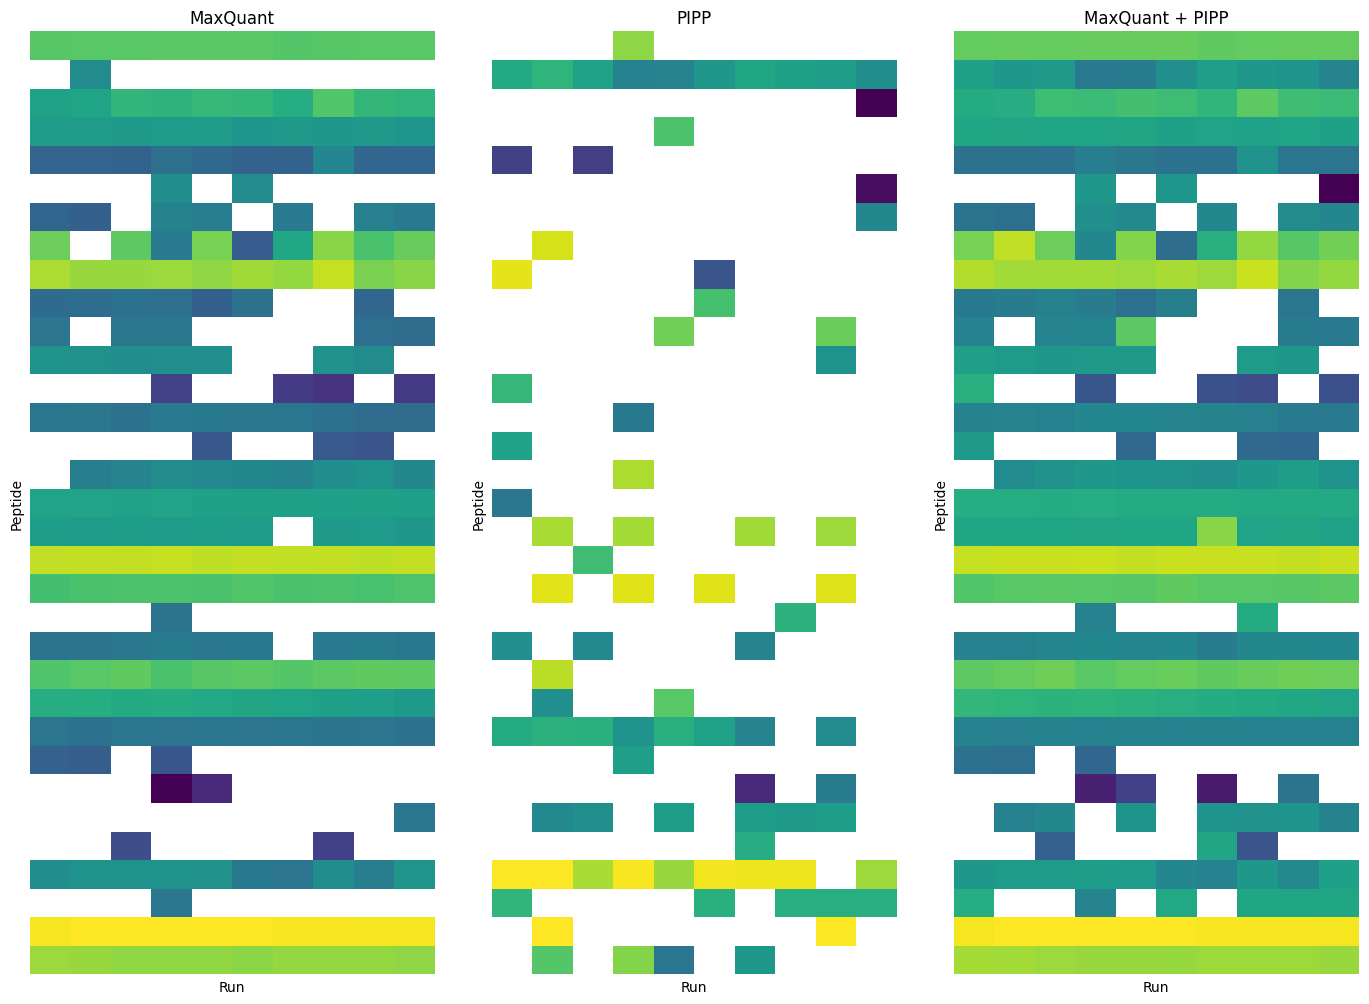

In [52]:
M = 200
n = min(M, ms1_expression.shape[0], ms2_expression.shape[0])

fig, axs = plt.subplots(figsize=(14, 10), ncols=3, nrows=1)
fig.tight_layout(pad=1.0)

# MaxQuant
ax = axs[0]
sns.heatmap(np.log2(ms2_expression.iloc[:n] + 1), ax=ax, cmap='viridis', 
            xticklabels=False, yticklabels=False, cbar=False)
ax.set_title('MaxQuant')
ax.set_xlabel('Run')
ax.set_ylabel('Peptide')

# PIPP
ax = axs[1]
sns.heatmap(np.log2(ms1_expression.iloc[:n] + 1), ax=ax, cmap='viridis', 
            xticklabels=False, yticklabels=False, cbar=False)
ax.set_title('PIPP')
ax.set_xlabel('Run')
ax.set_ylabel('Peptide')

# PIPP + MaxQuant
ax = axs[2]
sns.heatmap(np.log2(expression_fill + 1), ax=ax, cmap='viridis',
            xticklabels=False, yticklabels=False, cbar=False)
ax.set_title('MaxQuant + PIPP')
ax.set_xlabel('Run')
ax.set_ylabel('Peptide')


Let's compute the coefficient of variance for each peptide and plot it with the mean.

In [53]:
expression_cv_features = expression_features[['PrecursorID', 'Intensities']].copy()
expression_cv_features['Intensities'] = np.log2(expression_cv_features['Intensities'] + 1)

expression_cv_features = expression_cv_features.groupby('PrecursorID').agg(['mean', 'std'])
expression_cv_features['CV'] = expression_cv_features['Intensities']['std'] / expression_cv_features['Intensities']['mean']
expression_cv_features['CV2'] = expression_cv_features['CV'] ** 2

In [54]:
n = 10_000
random_indices = np.random.choice(range(len(expression_cv_features)), size=n, replace=False)

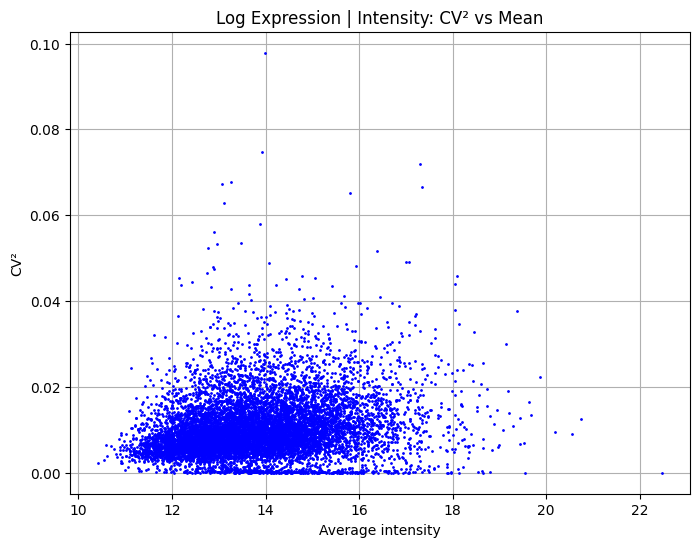

In [55]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(expression_cv_features['Intensities']['mean'].iloc[random_indices], expression_cv_features['CV2'].iloc[random_indices], s=1, color='blue')
ax.set_xlabel('Average intensity')
ax.set_ylabel('CV²')
ax.set_title('Log Expression | Intensity: CV² vs Mean')
ax.grid(True)
ax.set_axisbelow(True)

### Identification on held-out MS2 run

Let's hold out all the peptides in the MS2 dataset for a specific run and see how many of them are identified.

In [56]:
runs = ms1_data['Raw file'].unique()

run_to_benchmark = runs[0]
print('Run to benchmark: {}'.format(run_to_benchmark))

other_runs = runs[runs != run_to_benchmark]

ms2_data_subset = ms2_data[ms2_data['Raw file'] != run_to_benchmark]
ms2_embeddings_subset = ms2_embeddings[ms2_data['Raw file'] != run_to_benchmark]

ms2_data_benchmark = ms2_data[ms2_data['Raw file'] == run_to_benchmark].copy()
ms2_embeddings_benchmark = ms2_embeddings[ms2_data['Raw file'] == run_to_benchmark]

Run to benchmark: 20190122_HeLa_QC_Slot1-47_1_3219


In [57]:
k = 15

identities, confidence = model.propagate(ms2_data_benchmark, ms2_data_subset, k_neighbours=k)

computing prototypes...
computing 15-nearest neighbour prototypes...
computing confidence and selecting identities...


In [58]:
print(f"Number of prototypes: {ms2_data_subset['PrecursorID'].nunique()}")

Number of prototypes: 60544


In [59]:
ms2_data_benchmark['Identification'] = identities
ms2_data_benchmark['Identification Confidence'] = confidence

Let's plot the distribution of the confidence scores for the MS2 identifications. Additionally, we'll add a threshold to the plot, which we'll use to filter out low confidence identifications.

Text(0.21000000000000002, 5000, 'Peptides identified correctly: 33 (45.83%)')

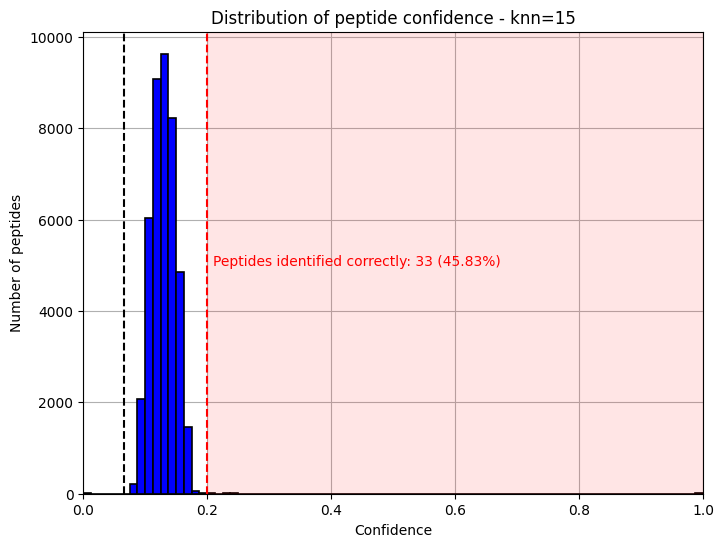

In [62]:
peptide_threshold = 0.2


fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(ms2_data_benchmark['Identification Confidence'], bins=80, color='blue', edgecolor='black', linewidth=1.2)
ax.set_xlabel('Confidence')
ax.set_ylabel('Number of peptides')
ax.set_title(f'Distribution of peptide confidence - knn={k}')
ax.set_xlim([0, 1])
ax.grid(True)
ax.set_axisbelow(True)

ax.axvline(x=peptide_threshold, color='red', linestyle='--')
ax.axvline(x=1/k, color='black', linestyle='--')
ax.axvspan(peptide_threshold, 1, alpha=0.1, color='red')

benchmark_threshold = ms2_data_benchmark[ms2_data_benchmark['Identification Confidence'] > peptide_threshold]
matches = np.sum(benchmark_threshold['PrecursorID'] == benchmark_threshold['Identification'])

identified_count = np.sum(ms2_data_benchmark['Identification Confidence'] > peptide_threshold)
ax.text(peptide_threshold + 0.01, 5000, f'Peptides identified correctly: {matches} ({matches / benchmark_threshold.shape[0] * 100:.2f}%)', color='red')

Let's plot the number of peptides identified correctly for different thresholds.

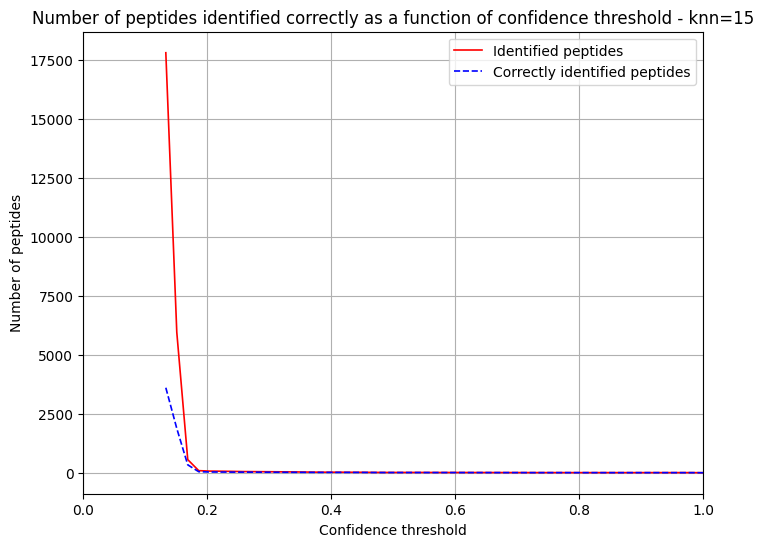

In [63]:
thresholds = np.linspace(1/k*2, 1, 50)
identified_counts = []
correct_counts = []

for threshold in thresholds:
    benchmark_threshold = ms2_data_benchmark[ms2_data_benchmark['Identification Confidence'] > threshold]
    matches = np.sum(benchmark_threshold['PrecursorID'] == benchmark_threshold['Identification'])
    identified_counts.append(benchmark_threshold.shape[0])
    correct_counts.append(matches)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(thresholds, identified_counts, color='red', linewidth=1.2, label='Identified peptides')
ax.plot(thresholds, correct_counts, color='blue', linewidth=1.2, linestyle='--', label='Correctly identified peptides')
ax.set_xlabel('Confidence threshold')
ax.set_ylabel('Number of peptides')
ax.set_title(f'Number of peptides identified correctly as a function of confidence threshold - knn={k}')
ax.set_xlim([0, 1])
ax.grid(True)
ax.set_axisbelow(True)
ax.legend()